> THIS NOTEBOK REQUIRES THE `convert_ids.ipynb` and `preprocessing.ipynb` TO BE RAN FIRST

# Ordering Characters in Movies by importance
The website [TMDB claims that](https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000003#59f73ca49251416e7100000e) roles for characters are ordered by importance, namely that major roles are always credited before small parts. 

We will use this for our advantage, to "boost" names of the characters in a movie that are more important, and "demote" names of characters that are less important. In turn this will help us to identify the main characters in a movie (for example the top 5 names), those that will have a bigger relevance in the movie. We will assume that characters with a bigger relevance will have a bigger impact on the audience compared to a character with little importance, and therefore will be very important for our analysis.

In [1]:
import requests
import pandas as pd
import numpy as np
from IPython.display import clear_output

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import token from config.py
from config import TMDB_API_TOKEN

In [3]:
raw_dir = './raw_data/'
tmp_dir = './tmp_data/'
processed_dir = './processed_data/'

## Fetch credits with single movie

In [4]:
# Request setup
headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {TMDB_API_TOKEN}"
}

def fetch_url(movie_id):
    """Fetches the url for a given movie ID"""
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits?language=en-US"
    return url

In [5]:
test_id = 577922

# Request the pageprops for a page
response = requests.get(fetch_url(test_id), headers=headers).json()
print(response)

{'id': 577922, 'cast': [{'adult': False, 'gender': 2, 'id': 1117313, 'known_for_department': 'Acting', 'name': 'John David Washington', 'original_name': 'John David Washington', 'popularity': 62.804, 'profile_path': '/qoOp8XvZ4v7B0C9ZmtoRCl9CDSO.jpg', 'cast_id': 12, 'character': 'The Protagonist', 'credit_id': '5cab21a50e0a264c7df637a6', 'order': 0}, {'adult': False, 'gender': 2, 'id': 11288, 'known_for_department': 'Acting', 'name': 'Robert Pattinson', 'original_name': 'Robert Pattinson', 'popularity': 50.743, 'profile_path': '/6RVxNlNmc0DIfZzaJKCJM43If3M.jpg', 'cast_id': 13, 'character': 'Neil', 'credit_id': '5cab21b70e0a264c80f63b9c', 'order': 1}, {'adult': False, 'gender': 1, 'id': 1133349, 'known_for_department': 'Acting', 'name': 'Elizabeth Debicki', 'original_name': 'Elizabeth Debicki', 'popularity': 32.368, 'profile_path': '/6H4mUQW1cKa9yivzwCPHoXe1UJn.jpg', 'cast_id': 14, 'character': 'Kat', 'credit_id': '5cab21c90e0a264c88f63209', 'order': 2}, {'adult': False, 'gender': 2, 'i

In [6]:
# Import ids dataframe
external_ids = pd.read_csv(processed_dir + 'movies_external_ids.csv')
display(external_ids.head())

# Import name_by_movie dataframe
name_by_movie = pd.read_csv(processed_dir + 'name_by_movie_df.csv')
display(name_by_movie.head())

# To save time, only consider the tmdb_ids that are in the name_by_movie dataframe
tmdb_ids_list = name_by_movie.merge(external_ids, left_on='wiki_ID', right_on='wikipedia_ID')['TMDB_ID'].dropna().astype(int).astype(str).unique()
display(tmdb_ids_list.shape)

# Set TMDB_ID as index
print(f"Is the TMDB_ID column in external_ids unique? {external_ids['TMDB_ID'].dropna().is_unique}")
lookup_ids = external_ids.dropna(subset=['TMDB_ID']).set_index('TMDB_ID').copy(deep=True)
display(lookup_ids.head())

,wikipedia_ID,IMDB_ID,TMDB_ID
0,22760465,ch0112831,NaN
1,185519,nm0158560,NaN
2,12754957,nm0704910,NaN
3,10111255,nm1016169,NaN
4,7669437,tt0000001,16612.0


,wiki_ID,char_words
0,975900,Lieutenant
1,7668793,Lieutenant
2,24226493,Lieutenant
3,3388805,Lieutenant
4,8231713,Lieutenant


(28053,)

Is the TMDB_ID column in external_ids unique? True


,wikipedia_ID,IMDB_ID
TMDB_ID,,
16612.0,7669437,tt0000001
16613.0,9996498,tt0000002
88013.0,6431647,tt0000003
16622.0,9999926,tt0000004
16624.0,73372,tt0000005


While running the code below, we realised that there was an overwhelming amounts of uncredited characters indicated by `(uncredited)` in the TMDB data, which didn't have any name. We decided to remove these characters from our analysis, as they would not be useful, to save space

In [7]:
# For every movie ID (TMDB IDs), request the credits
tmp_ids = []
tmp_names = []
tmp_order = []

for movie_id, idx in zip(tmdb_ids_list, range(len(tmdb_ids_list))):
    # Request
    url = fetch_url(movie_id)
    response = requests.get(url, headers=headers).json()

    # If case doesn't exist, skip
    if 'cast' not in response or not response['cast']:
        continue    

    # Response contains a list called cast, an ordered list of characters by importance
    for char in response['cast']:
        # If name contains '(uncredited)' or '(voice)', skip
        if '(uncredited)' in char['character'] or '(voice)' in char['character']:
            continue

        # Store values
        tmp_ids.append(movie_id)
        tmp_names.append(char['character'])
        tmp_order.append(char['order'])

    # Prettyyyy progress
    clear_output(wait=True)   
    print(f"Finished {idx+1}/{len(tmdb_ids_list)} ({movie_id})")

    # if idx > 10:
    #     break

# Save the credits in a dataframe
credits_df = pd.DataFrame({'TMDB_ID': tmp_ids, 'credits': tmp_names, 'order': tmp_order})
credits_df['credits'] = credits_df['credits'].str.split() # Split the names into a list by space
credits_df = credits_df.explode('credits')
display(credits_df)

# Save as tmp
credits_df.to_csv(tmp_dir + 'credits_df.csv', index=False)

Finished 28053/28053 (66215)


,TMDB_ID,credits,order
0,10016,Lt.,0
0,10016,Melanie,0
0,10016,Ballard,0
1,10016,James,1
1,10016,'Desolation',1
...,...,...,...
542136,66215,Father,6
542137,66215,Simbu's,7
542137,66215,Mother,7
542138,66215,Simbhu's,8


<Axes: xlabel='credits'>

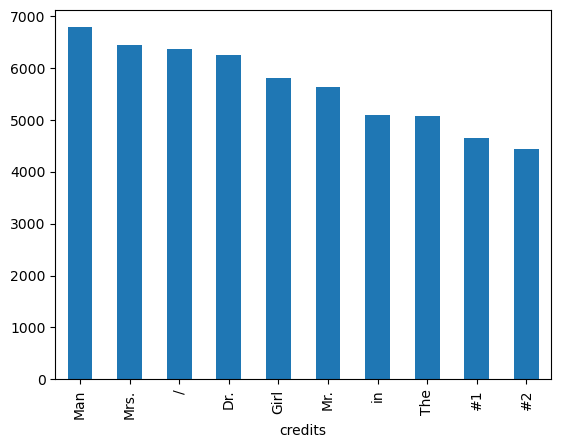

In [8]:
# Import credits_df
credits_df = pd.read_csv(tmp_dir + 'credits_df.csv')

# Plot for fun the top 5 most used character names
credits_df['credits'].value_counts().head(10).plot(kind='bar')

# There are a lot of titles (officer, doctor, ...) but this is all taken care
# of when merging with the name_by_movie dataframe

In [9]:
# We now want to merge the credits_df with the name_by_movie dataframe

# Add the wiki_ID to the credits_df with the help of the lookup table
credits_df_wiki_ids = credits_df.merge(lookup_ids, left_on='TMDB_ID', right_index=True).copy(deep=True)

# Merge the credits_df with the name_by_movie dataframe
name_with_order = name_by_movie.merge(credits_df_wiki_ids, left_on=['wiki_ID', 'char_words'], right_on=['wikipedia_ID', 'credits'], how='left').copy(deep=True)

# Keep only important comulmns: wiki_ID, char_words, order
name_with_order_clean = name_with_order[['wiki_ID', 'char_words', 'order']].copy(deep=True)
display(name_with_order_clean)

,wiki_ID,char_words,order
0,975900,Lieutenant,NaN
1,7668793,Lieutenant,27.0
2,24226493,Lieutenant,2.0
3,3388805,Lieutenant,3.0
4,3388805,Lieutenant,6.0
...,...,...,...
200546,24341999,Dagen,4.0
200547,43452,Auda,2.0
200548,11372598,Bonni,NaN
200549,2472440,Kary,11.0


In [11]:
# Compute how many characters don't have an order
print("Number of character names with an order: {} out of {} ({:.2f}%)".format(name_with_order_clean['order'].notna().sum(), name_with_order_clean.shape[0], name_with_order_clean['order'].notna().sum()/name_with_order_clean.shape[0]*100))

# Save in processed
name_with_order_clean.to_csv(processed_dir + 'name_by_movie_df.csv', index=False)

Number of character names with an order: 161184 out of 200551 (80.37%)


## Results
With this extra information, for the rest of this project:
- The order of the characters are indicated by a number in the `order` column, which are each relative to one movie.
- The lower the `order` value, the more important the characeter, and thus the character's name, are.
- Characters with NaN values do not have a particular order, so they should be treated as having an infintely large order value.